To do the sunrise/sunset calculations you'll need to do:

```
mamba install ephem
```

(read_cabauw)=
# Read cabauw data

This notebook opens and reads two months of cabauw data: July, 2014 and
December 2014.  It combines those two days and the measurements we care
about in a new file called cabauw_ubc.nc

In [1]:
import glob
from netCDF4 import Dataset
from dateutil.parser import parse
import datetime
import numpy as np
import matplotlib.dates as mdates
from pathlib import Path

filelist=['cesar_nubiscope_cloudcover_la1_t10_v1.0_201407.nc',
          'cesar_nubiscope_cloudcover_la1_t10_v1.0_201412.nc',
          'cesar_surface_flux_lc1_t10_v1.0_201407.nc',
          'cesar_surface_flux_lc1_t10_v1.0_201412.nc',
          'cesar_surface_meteo_lc1_t10_v1.0_201407.nc',
          'cesar_surface_meteo_lc1_t10_v1.0_201412.nc',
          'cesar_tower_meteo_lb1_t10_v1.1_201407.nc',
          'cesar_tower_meteo_lb1_t10_v1.1_201412.nc']

The make_date function takes an open CESAR ncfile and turns the time
vector from hours past the start date into a python datetime object
in UTC.  It uses the dateutil parse function to turn the date_start_of_data string into a date.  

This function is used in the cells below to create two dictionaries:

1. **data_dict** with six keys for the 3 file/2 month combinations
   with each (file,month) entry holding a dictionary
   with the numpy array data for the file variables (F, UST, etc.)
    
2. **var_attr** with a key for each variable holding dictionaries with
   the variable attributes (units, long name, etc.)

In [2]:
def make_date(ncfile):
    """
    ncfile:  open netCDF4 Dataset
    returns:
       numpy array of datetime objects
    """
    the_time=f.variables['time'][...]
    start_date=f.variables['product'].date_start_of_data
    start_date = parse(start_date)
    time_vec=[]
    for the_hour in the_time:
        time_vec.append(start_date + datetime.timedelta(hours=float(the_hour)))
    time_vec=np.array(time_vec)
    time_vec=time_vec.reshape(-1,24,6)
    return time_vec

Loop through all the files and make a dictionary with keys determined
by the netcdf file attributes.  Initially the dictionary contains the
filename, start_date, lat, lon and start time.

In [3]:
def get_attrs(ncvar):
    """
        input: open netcdf variable handle
        output: dictionary containing name,attribute pairs
    """
    attributes=ncvar.ncattrs()
    attr_dict={}
    for attr in attributes:
        attr_dict[attr]=getattr(ncvar,attr)
    return attr_dict

In [4]:
data_dir = Path.home() / "Dropbox/phil_files/a500/data/cabauw"
all_files=data_dir.glob('cesar*.nc')
data_dict={}
var_attrs={}
for the_file in all_files:
    str_name = str(the_file)
    if str_name.find('nubiscope') > -1:
        #
        # skip cloud data
        #
        continue
    with Dataset(the_file,'r') as f:
        details=f.variables['iso_dataset']
        attr_dict=get_attrs(details)
        lon=attr_dict['westbound_longitude']
        lat=attr_dict['northbound_latitude']
        title=attr_dict['title'].split()
        the_time = make_date(f)
        #
        # turn a title like:
        #"CESAR surface fluxes validated and gap filled"
        # into the string: surface_fluxes
        #
        filetype='{}_{}'.format(*title[1:3])
        start_date=f.variables['product'].date_start_of_data
        start_date=parse(start_date)
        start_month=start_date.strftime('%Y%m')
        print(f"{str_name=}, {filetype=}")
    data_dict[filetype,start_month]=dict(name=the_file,timevec=the_time,lon=lon,lat=lat,
                                        start_date=start_date)
#
#  lat and lon shouldn't change, use the last values for the netcdf file attribute
#
for name in ['lat','lon']:
    var_attrs[name]=data_dict[filetype,start_month][name]

str_name='/Users/phil/Dropbox/phil_files/a500/data/cabauw/cesar_surface_flux_lc1_t10_v1.0_201407.nc', filetype='surface_fluxes'
str_name='/Users/phil/Dropbox/phil_files/a500/data/cabauw/cesar_surface_flux_lc1_t10_v1.0_201412.nc', filetype='surface_fluxes'
str_name='/Users/phil/Dropbox/phil_files/a500/data/cabauw/cesar_tower_meteo_lb1_t10_v1.1_201412.nc', filetype='tower_meteorological'
str_name='/Users/phil/Dropbox/phil_files/a500/data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_201412.nc', filetype='meteorological_surface'
str_name='/Users/phil/Dropbox/phil_files/a500/data/cabauw/cesar_tower_meteo_lb1_t10_v1.1_201407.nc', filetype='tower_meteorological'
str_name='/Users/phil/Dropbox/phil_files/a500/data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_201407.nc', filetype='meteorological_surface'


Now loop through the dictionary and add the flux and tower variables.
Each variable is a linear vector of measurements taken every 10 minutes, and
for tower variables, at 7 levels.

The numpy command:
var.reshape(-1,24,6,7)
takes the linear vector and folds it into either 28,29,30,31 days (depending on month)
24 hours, 6 10 minute intervals, and 7 levels

That allows us to do an hourly average by saying:
var.mean(axis=2)  to average over the 6 10 minute measurements.

## Sorting by month

This cell goes through the data_dict dictionaries and combines the six
(file,month) keys into two dictionaries, one for each month.

In [5]:
#
# collect all the data from the three files into a dictionary indexed
# by month called month_dict
#
#  use defaultdict(dict) so that every time we add a new month
#  we create an empty dictionary to hold the variables
#  
#
from collections import defaultdict
month_dict=defaultdict(dict)
for the_key in data_dict.keys():
    var_dict=data_dict[the_key]
    the_month=the_key[1]
    print('working on: ',the_month)
    if the_key[0] == 'tower_meteorological':
        with Dataset(var_dict['name'],'r') as f:
            if 'has_time' not in month_dict[the_month]:
                month_dict[the_month]['timevec'] = var_dict['timevec']
                month_dict[the_month]['has_time']=True
            month_dict[the_month]['z'] = f.variables['z'][...]
            for var in ['F','TA','TD','Q','D']:
                month_dict[the_month][var] = f.variables[var][...].reshape(-1,24,6,7)
                var_attrs[var]=get_attrs(f.variables[var])
    elif the_key[0] == 'surface_fluxes': 
        with Dataset(var_dict['name'],'r') as f:
            for var in ['H','UST','LE']:
                month_dict[the_month][var] = f.variables[var][...].reshape(-1,24,6)
                var_attrs[var]=get_attrs(f.variables[var])
    elif the_key[0] == 'meteorological_surface': 
        with Dataset(var_dict['name'],'r') as f:
            for var in ['P0','TA002','Q002','F010']:
                month_dict[the_month][var] = f.variables[var][...].reshape(-1,24,6)
                var_attrs[var]=get_attrs(f.variables[var])
    elif the_key[0] == 'scanning_radiometer':
        pass
    else:
        raise ValueError("didn't recognize {}".format(the_key[0]))
print('finished: ',month_dict.keys())

working on:  201407
working on:  201412
working on:  201412
working on:  201412
working on:  201407
working on:  201407
finished:  dict_keys(['201407', '201412'])


We'll need to know sunrise, sunset and solar noon to interpret our
data.  Here is how you find these with the 
[pyephem](http://stackoverflow.com/questions/2637293/calculating-dawn-and-sunset-times-using-pyephem) module

In [6]:
import ephem
for the_month in month_dict.keys():
    var='tower_meteorological'
    start_time=month_dict[the_month]['timevec'][0,0,0]
    cabauw=ephem.Observer()
    cabauw.date=start_time
    cabauw.lon = var_attrs['lon']
    cabauw.lat = var_attrs['lat']
    sunrise=cabauw.next_rising(ephem.Sun())
    noon = cabauw.next_transit(ephem.Sun(),start=sunrise)
    sunset = cabauw.next_setting(ephem.Sun())
    print('sunrise is {} UTC'.format(sunrise))
    print('solar noon {} UTC'.format(noon))
    print('sunset is {} UTC'.format(sunset))

sunrise is 2014/7/1 03:24:19 UTC
solar noon 2014/7/1 11:44:09 UTC
sunset is 2014/7/1 20:03:38 UTC
sunrise is 2014/12/1 07:25:04 UTC
solar noon 2014/12/1 11:29:17 UTC
sunset is 2014/12/1 15:33:10 UTC


## Data first look

starting:  dict_keys(['201407', '201412'])
finished plot:  dict_keys(['201407', '201412'])


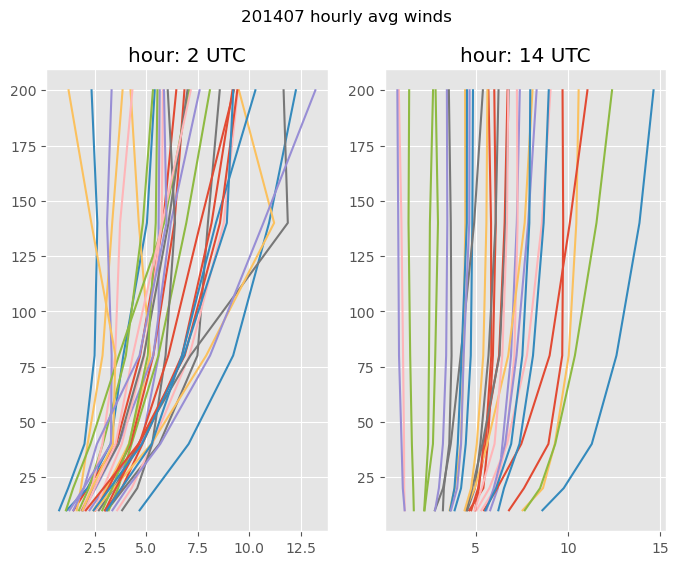

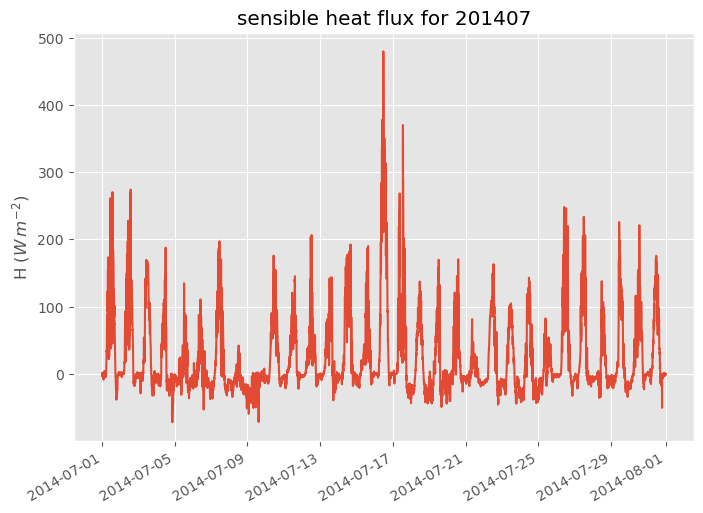

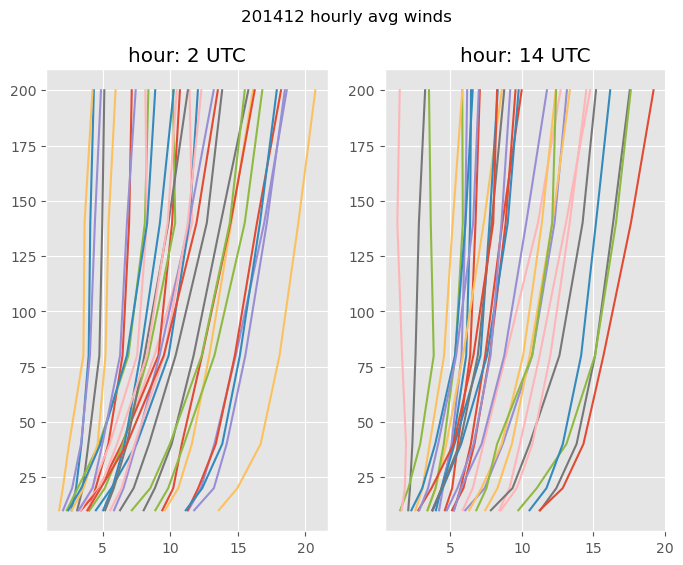

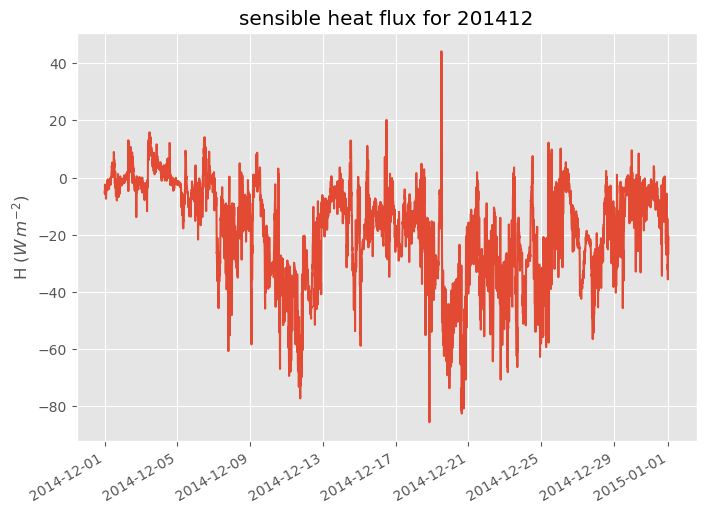

In [7]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.close('all')
print('starting: ',month_dict.keys())    
for the_month in month_dict.keys():
    hourly_wind_avg = month_dict[the_month]['F'].mean(axis=2)
    z=month_dict[the_month]['z']
    hour=2
    fig,ax=plt.subplots(1,2,figsize=(8,6))
    ax[0].plot(hourly_wind_avg[:,hour,:].T,z)
    ax[0].set(title='hour: {} UTC'.format(hour))
    hour=14
    ax[1].plot(hourly_wind_avg[:,hour,:].T,z)
    ax[1].set(title='hour: {} UTC'.format(hour))
    fig.suptitle('{} hourly avg winds'.format(the_month))

    #
    # date plotting tips at http://matplotlib.org/users/recipes.html
    #
    the_time = month_dict[the_month]['timevec']
    H=month_dict[the_month]['H']
    fig,ax=plt.subplots(1,1,figsize=(8,6))
    fig.autofmt_xdate()
    ax.plot(the_time.ravel(),H.ravel())
    title='sensible heat flux for {}'.format(the_month)
    ax.set(title=title,ylabel='H $(W\,m^{-2})$')
print('finished plot: ',month_dict.keys())

## Checkpoint all the data into one netcdf file

I want to save month_dict into a netcdf file so we don't need
to repeat this processing but can start with a merged dataset
that has all days of interest and all
instruments in a single place.   To do that, I group the measurements
into individual days using [netcdf groups](http://unidata.github.io/netcdf4-python)

I transfer all the attributes I read into the var_attrs dict so I maintain
the original metadata as much as possible

In [8]:
def write_attrs(ncvar,attr_dict):
    for name,item in attr_dict.items():
        if name != '_FillValue':
            setattr(ncvar,name,item)
    return None

from netCDF4 import Dataset
import os
filename='cabauw_ubc.nc'
if os.path.exists(filename):
    os.remove(filename)   
with Dataset(filename,'w') as ncout:
    the_months = month_dict.keys()
    for the_month in the_months:
        speed=month_dict[the_month]['F']
        days_name='days{:2d}'.format(speed.shape[0])
        dimnames=[days_name,'hours','min10','z']
        dim_info=zip(dimnames,speed.shape)
        for name,length in dim_info:     
            try:
                ncout.createDimension(name,length) 
            except RuntimeError:
                pass
        nc_month='m{}'.format(the_month)
        date_group=ncout.createGroup(nc_month)
        setattr(date_group,'month',the_month)
        for var in ['H','LE','UST','P0','TA002','Q002','F010']:
            the_data=month_dict[the_month][var]
            var_nc=date_group.createVariable(var,the_data.dtype,
                                             [days_name,'hours','min10'])
            var_nc[...]=the_data[...]
            write_attrs(var_nc,var_attrs[var])
        for var in ['TA','D','Q','TD','F']:
            the_data=month_dict[the_month][var]
            var_nc=date_group.createVariable(var,the_data.dtype,
                                             [days_name,'hours','min10','z'])
            var_nc[...]=the_data[...]
            write_attrs(var_nc,var_attrs[var])

        the_time=month_dict[the_month]['timevec']
        float_time=np.array([item.timestamp() for item in the_time.flat])
        float_time=float_time.reshape(-1,24,6)   
        time_nc=date_group.createVariable('time',float_time.dtype,
                                     [days_name,'hours','min10']) 
        time_nc[...]=float_time[...]
        time_nc.timezone='UTC'
        time_nc.comment='convert using datetime.fromtimestamp(var,pytz.utc)'
        try:
            z=month_dict[the_month]['z']
            z_nc=ncout.createVariable('z',z.dtype,['z'])
            z_nc[...]=z[...]
        except RuntimeError:
            #
            # only create ncout z vector once
            #
            pass
        ncout.history='written by read_cabauw.ipynb'
        for var in ['lat','lon']:
            setattr(ncout,var,float(var_attrs[var]))
        ncout.lat_units='degrees north'
        ncout.lon_units='degrees east'
        filelist=[]
        for key,value in data_dict.items():
            filelist.append('{};'.format(value['name']))
        filelista=np.array(filelist)
        setattr(ncout,'filelist',filelist)
            

In [9]:
!ncdump -h cabauw_ubc.nc

netcdf cabauw_ubc {
dimensions:
	days31 = 31 ;
	hours = 24 ;
	min10 = 6 ;
	z = 7 ;
variables:
	float z(z) ;

// global attributes:
		:history = "written by read_cabauw.ipynb" ;
		:lat = 51.97 ;
		:lon = 4.926 ;
		:lat_units = "degrees north" ;
		:lon_units = "degrees east" ;
		string :filelist = "/Users/phil/Dropbox/phil_files/a500/data/cabauw/cesar_surface_flux_lc1_t10_v1.0_201407.nc;", "/Users/phil/Dropbox/phil_files/a500/data/cabauw/cesar_surface_flux_lc1_t10_v1.0_201412.nc;", "/Users/phil/Dropbox/phil_files/a500/data/cabauw/cesar_tower_meteo_lb1_t10_v1.1_201412.nc;", "/Users/phil/Dropbox/phil_files/a500/data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_201412.nc;", "/Users/phil/Dropbox/phil_files/a500/data/cabauw/cesar_tower_meteo_lb1_t10_v1.1_201407.nc;", "/Users/phil/Dropbox/phil_files/a500/data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_201407.nc;" ;

group: m201407 {
  variables:
  	float H(days31, hours, min10) ;
  		H:units = "W m-2" ;
  		H:long_name = "MERGED Surface sensible heat 